In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/Shareddrives/IDS561

/content/drive/Shareddrives/IDS561


In [6]:
import pandas as pd
df=pd.read_csv('/content/drive/Shareddrives/IDS561/data_preprocessing_op.csv')
df.head()

,Unnamed: 0,text,retweet_count,favorite_count,word_count,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Overall Sentiment,Overall Sentiment Description
0,0,BREAKING: Pfizer ‘Fetal Cell’ Whistleblower M...,0,0,16,0.000001,1.000001,0.000001,0.000001,Neutral
1,1,Toronto lockdown czar’s husband has ‘financia...,0,0,11,0.000001,1.000001,0.000001,0.000001,Neutral
2,2,"&amp; year olds, ""ACCIDENTALLY"" given Pfizer ...",0,0,18,0.000001,0.758001,0.242001,-0.585899,Negative
3,3,You will find here what changes your life for...,0,0,14,0.225001,0.775001,0.000001,0.440401,Neutral
4,4,"When Twitter gives mewarning about anything, ...",0,0,20,0.130001,0.870001,0.000001,0.400501,Neutral


In [7]:
#dropping first column
df = df.iloc[: , 1:]
df.head()

,text,retweet_count,favorite_count,word_count,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Overall Sentiment,Overall Sentiment Description
0,BREAKING: Pfizer ‘Fetal Cell’ Whistleblower M...,0,0,16,0.000001,1.000001,0.000001,0.000001,Neutral
1,Toronto lockdown czar’s husband has ‘financia...,0,0,11,0.000001,1.000001,0.000001,0.000001,Neutral
2,"&amp; year olds, ""ACCIDENTALLY"" given Pfizer ...",0,0,18,0.000001,0.758001,0.242001,-0.585899,Negative
3,You will find here what changes your life for...,0,0,14,0.225001,0.775001,0.000001,0.440401,Neutral
4,"When Twitter gives mewarning about anything, ...",0,0,20,0.130001,0.870001,0.000001,0.400501,Neutral


In [8]:
#distribution of overall sentiments
dist_overall_sentiment=df['Overall Sentiment Description']
dist_overall_sentiment=pd.DataFrame(dist_overall_sentiment)
dist_overall_sentiment.head()
dist_overall_sentiment.drop_duplicates()
dist_overall_sentiment['frequency']=df['Overall Sentiment Description'].map(df['Overall Sentiment Description'].value_counts())
dist_overall_sentiment.drop_duplicates()

,Overall Sentiment Description,frequency
0,Neutral,66544
2,Negative,34182
96,Positive,8562


No handles with labels found to put in legend.


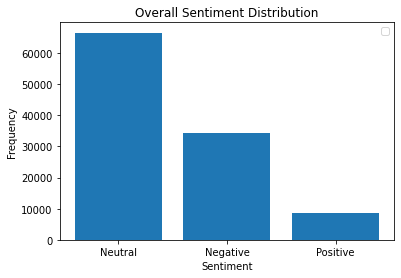

In [9]:
import numpy as np
import matplotlib.pyplot as plt
 
plt.bar(dist_overall_sentiment['Overall Sentiment Description'],dist_overall_sentiment['frequency'])
 
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Overall Sentiment Distribution")
plt.legend()
plt.show()

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.figure_factory as ff
import cv2
from PIL import Image
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer



import random
plt.rc('figure',figsize=(17,13))

# Package for requests
import requests

# Packages to preprocess the data
import re

# Packages for removing some unwanted outputs("warnings")
import warnings
warnings.filterwarnings("ignore")

Output hidden; open in https://colab.research.google.com to view.

In [11]:
#Setting up drive, installing spark and importing required libraries
%cd /content/drive/Shareddrives/IDS561
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -v https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!ls
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/Shareddrives/IDS561/spark-3.1.2-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark import SparkContext
sc =SparkContext.getOrCreate()

/content/drive/Shareddrives/IDS561
--2021-11-15 02:56:49--  https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228834641 (218M) [application/x-gzip]
Saving to: ‘spark-3.1.2-bin-hadoop3.2.tgz.30’

spark-3.1.2-bin-had 100%[===================>] 218.23M  32.0MB/s    in 6.7s    

2021-11-15 02:57:06 (32.8 MB/s) - ‘spark-3.1.2-bin-hadoop3.2.tgz.30’ saved [228834641/228834641]

'1) Data import and consolidate.ipynb'	 spark-3.1.2-bin-hadoop3.2.tgz.15
'2) MissingData .ipynb'			 spark-3.1.2-bin-hadoop3.2.tgz.16
'3) Data_preprocessing.ipynb'		 spark-3.1.2-bin-hadoop3.2.tgz.17
'4 Exploratory_Analysis.ipynb'		 spark-3.1.2-bin-hadoop3.2.tgz.18
'5) Modelling.ipynb'			 spark-3.1.2-bin-hadoop3.2.tgz.19
 Archive				 spark-3.1.2-bin-hadoop3.2.tgz.2
 cleaned_tweets.csv	

In [12]:
df['text_word']=df['text']
#Cleaning up the tweets text
#Remove twitter handlers
import re
df.text_word = df.text_word.apply(lambda x:re.sub('@[^\s]+','',x))
#remove hashtags
df.text_word = df.text_word.apply(lambda x:re.sub(r'\B#\S+','',x))
# Remove URLS
df.text_word = df.text_word.apply(lambda x:re.sub(r"http\S+", "", x))
# Remove all the special characters
df.text_word = df.text_word.apply(lambda x:' '.join(re.findall(r'\w+', x)))
#remove all single characters
df.text_word = df.text_word.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Substituting multiple spaces with single space
df.text_word = df.text_word.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
#Converting everything to uppercase
df.text_word=df['text_word'].str.lower()
df['text_word'] = df['text_word'].str.replace('rt','')
print(df.head())

                                                text  ...                                          text_word
0   BREAKING: Pfizer ‘Fetal Cell’ Whistleblower M...  ...  breaking pfizer fetal cell whistleblower melis...
1   Toronto lockdown czar’s husband has ‘financia...  ...  toronto lockdown czarhusband has financial tie...
2   &amp; year olds, "ACCIDENTALLY" given Pfizer ...  ...  amp year olds accidentally given pfizer vaccin...
3   You will find here what changes your life for...  ...  you will find here what changes your life for ...
4   When Twitter gives mewarning about anything, ...  ...  when twitter gives mewarning about anything it...

[5 rows x 10 columns]


In [13]:
# creating differnt dataframes and printing top 10 tweets in each category
options = ['Negative'] 
df_negative=df[df['Overall Sentiment Description'].isin(['Negative'] )]
df_negative = df_negative.sort_values(by=['Overall Sentiment'], ascending=True)
print(df_negative.head(10))
options = ['Positive'] 
df_positive=df[df['Overall Sentiment Description'].isin(['Positive'])]
df_positive = df_positive.sort_values(by=['Overall Sentiment'], ascending=False)
print(df_positive.head(10))
options = ['Neutral'] 
df_neutral=df[df['Overall Sentiment Description'].isin(['Neutral'])]
df_neutral = df_neutral.sort_values(by=['Overall Sentiment'], ascending=True)
print(df_neutral.head(10))

                                                    text  ...                                          text_word
61249   Your vaccines are killing all of us you are l...  ...  your vaccines are killing all of us you are li...
83360  got pfizer first shot wasn’t bad my arm hust h...  ...  got pfizer first shot wasnbad my arm hust hu b...
650    Lies. Lies. Lies. This tyrannical admin is bui...  ...  lies lies lies this tyrannical admin is built ...
24799   THEY say "this is misleading"\n&amp; SOMEONE ...  ...  they say this is misleading amp someone died t...
21801  im literally crying, im gonna kill any dumb as...  ...  im literally crying im gonna kill any dumb ass...
15490  im literally crying, im gonna kill any dumb as...  ...  im literally crying im gonna kill any dumb ass...
34851   I’m really not happy with my kids being jabbe...  ...  ireally not happy with my kids being jabbed wi...
895     It'sfreaking fear mongering lie. No worse tha...  ...  it sfreaking fear mongering lie n

(-0.5, 399.5, 199.5, -0.5)

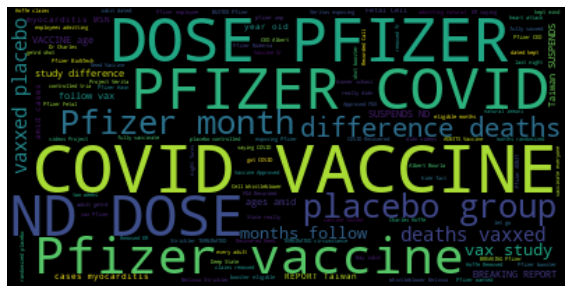

In [14]:
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

tweet_All = " ".join(review for review in df.text)


fig, ax = plt.subplots(1, 1, figsize  = (10,10))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=48, max_words=100, background_color="black").generate(tweet_All)

# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')

ax.axis('off')

In [15]:
def clean_text(text):
    
    text = str(text).lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    return text
df['text'] = df['text'].apply(lambda x:clean_text(x))
df['text']


0          breaking pfizer ‘fetal cell’ whistleblower me...
1          toronto lockdown czar’s husband has ‘financia...
2          amp year olds accidentally given pfizer vacci...
3          you will find here what changes your life for...
4          when twitter gives mewarning about anything i...
                                ...                        
109283           pfizer vice president speaksany questions 
109284    this is terrific for all vaxxed people\n\nthey...
109285     yeah all those heart attacks it’s bacon and e...
109286    the fda and cdc have just authorized pfizer va...
109287    as the vaxxed folks would say at least he didn...
Name: text, Length: 109288, dtype: object

In [16]:
#most favourite and retweeted tweet
print(f" Maximum number of retweets {df.retweet_count.max()}")
print(f" Maximum number of favorites {df.favorite_count.max()}")

 Maximum number of retweets 0
 Maximum number of favorites 0


In [17]:
Most_Positive = df[df['Positive Sentiment'].between(0.4,1)]
Most_Negative = df[df['Negative Sentiment'].between(0.25,1)]

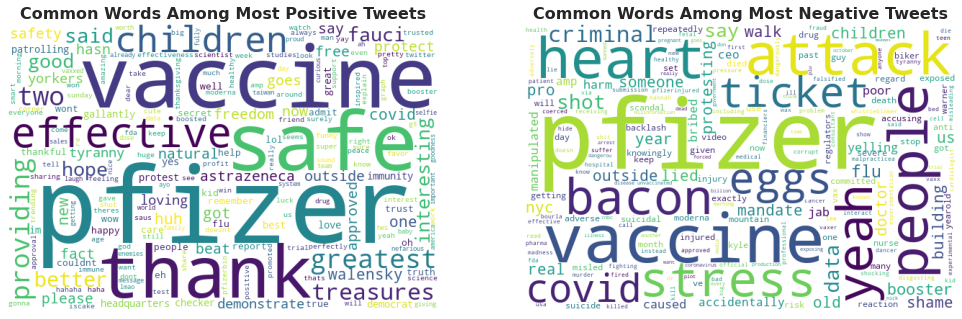

In [18]:
Most_Positive_text = ' '.join(Most_Positive.text)
Most_Negative_text = ' '.join(Most_Negative.text)


pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Positive_text)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Negative_text)

plt.subplot(1,2,1)
plt.title('Common Words Among Most Positive Tweets',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Common Words Among Most Negative Tweets',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

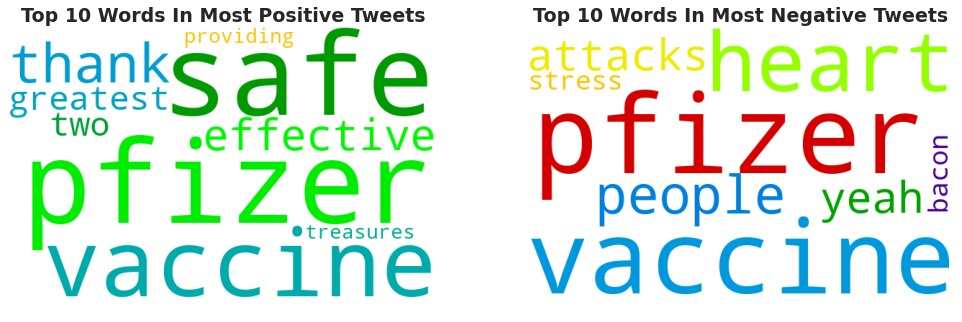

In [ ]:
l_t = Most_Positive_text

w1_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w1_dict[w] = w1_dict.get(w,0)+1
w1_dict = {k: v for k, v in sorted(w1_dict.items(), key=lambda item: item[1],reverse=True)}

l_t = Most_Negative_text
w2_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w2_dict[w] = w2_dict.get(w,0)+1
w2_dict = {k: v for k, v in sorted(w2_dict.items(), key=lambda item: item[1],reverse=True)}

top_10_pos = list(w1_dict.keys())[:10]
top_10_neg = list(w2_dict.keys())[:10]

plt.subplot(1,2,1)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral',background_color='white').generate(' '.join(top_10_pos))
plt.title('Top 10 Words In Most Positive Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.subplot(1,2,2)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral',background_color='white').generate(' '.join(top_10_neg))
plt.title('Top 10 Words In Most Negative Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.show()

                word frequency
0                        34181
298           pfizer       938
349     CovidVaccine       518
263           Pfizer       264
265          COVID19       149
7              covid       108
40         Covid1984        99
80               USA        89
302          FuckOff        53
41       DoNotComply        50
12           vaccine        49
128         Vanguard        44
421              CNN        32
498               No        32
5            Moderna        31
395  VaccinePassport        28
299     ChurchOfWoke        27
514         SARSCoV2        25
24       myocarditis        25
220         Paxlovid        25


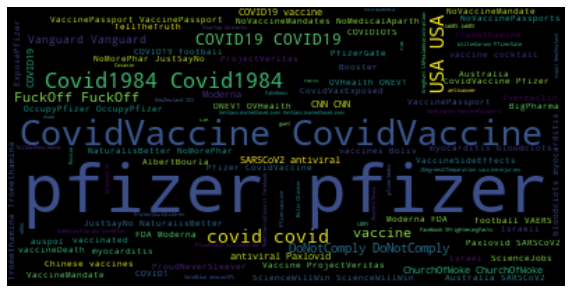

In [ ]:
#printing top negative tweets


#getting all the tweets in 1 string
df_negative['trends']=df_negative['text_original']
df_negative['trends']=''
rows,column = df_negative.shape
str_head=''
i=0
for i in range(0,rows-2):
  str=''
  mentions = re.findall("#([a-zA-Z0-9_]{1,50})",df_negative.iloc[i]['text_original'])
  #print(mentions)
  for j in range(0,len(mentions)):
    str=str+mentions[j]+' '
  df_negative['trends']=str
  str_head=str_head+' '+str
  #print(df_negative.iloc[i]['trends'])
#print(str_head)



#Popular negative tweets in image
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
fig, ax = plt.subplots(1, 1, figsize  = (10,10))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=48, max_words=100, background_color="black").generate(str_head)
# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.axis('off')


#Word count operation
from pyspark import SparkContext
sc =SparkContext.getOrCreate()
rdd = sc.parallelize([str_head])
counts = rdd.flatMap(lambda line: line.split(" ")).map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b).collect()
#print(counts)


#Printing out the word count list
column_names = ["word", "frequency"]
#df = pd.DataFrame(np.zeros((len(counts), 2)),columns = column_names)
df_negative_frequency = pd.DataFrame(columns = column_names)
#print(df_negative_frequency)
i=0
for i in range(0,len(counts)):
  
  a,b=counts[i]
  df_negative_frequency = df_negative_frequency.append({'word' : a, 'frequency' : b}, ignore_index = True)
  #df['word'].values[i],df['word_count'].values[i]
pd.set_option("display.max_rows", None, "display.max_columns", None)
#print(df_negative_frequency.sort_values('frequency',ascending=False))
df_negative_frequency=df_negative_frequency.sort_values('frequency',ascending=False)
print(df_negative_frequency.head(20))
#df.to_csv('Word_frequency.csv')



                word frequency
0                         8561
144          COVID19       229
139           Pfizer       102
12                 1        89
3            vaccine        29
135             gbbo        17
171          covid19        11
21           Vaccine        11
34   CovidVaxExposed        11
211           Israel        11
230            COVID        10
210         Insiders        10
33       mRNAvaccine         9
147       vaccinated         9
168           pfizer         8
9            NewYork         8
166         SARSCoV2         7
143       manifs13no         7
175     CovidVaccine         7
6            Moderna         7


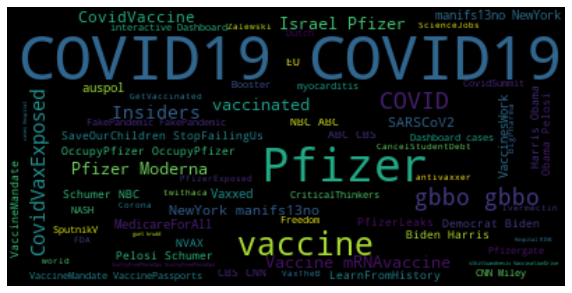

In [ ]:
#printing top positive tweets



#getting all the tweets in 1 string
df_positive['trends']=df_positive['text_original']
df_positive['trends']=''
rows,column = df_positive.shape
str_head=''
i=0
for i in range(0,rows-2):
  str=''
  mentions = re.findall("#([a-zA-Z0-9_]{1,50})",df_positive.iloc[i]['text_original'])
  #print(mentions)
  for j in range(0,len(mentions)):
    str=str+mentions[j]+' '
  df_positive['trends']=str
  str_head=str_head+' '+str
  #print(df_negative.iloc[i]['trends'])
#print(str_head)



#Popular positive tweets in image
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
fig, ax = plt.subplots(1, 1, figsize  = (10,10))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=48, max_words=100, background_color="black").generate(str_head)
# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.axis('off')


#Word count operation
from pyspark import SparkContext
sc =SparkContext.getOrCreate()
rdd = sc.parallelize([str_head])
counts = rdd.flatMap(lambda line: line.split(" ")).map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b).collect()
#print(counts)



#Printing out the word count list
column_names = ["word", "frequency"]
#df = pd.DataFrame(np.zeros((len(counts), 2)),columns = column_names)
df_positive_frequency = pd.DataFrame(columns = column_names)
#print(df_positive_frequency)
i=0
for i in range(0,len(counts)):
  
  a,b=counts[i]
  df_positive_frequency = df_positive_frequency.append({'word' : a, 'frequency' : b}, ignore_index = True)
  #df['word'].values[i],df['word_count'].values[i]
pd.set_option("display.max_rows", None, "display.max_columns", None)
#print(df_positive_frequency.sort_values('frequency',ascending=False))
df_positive_frequency=df_positive_frequency.sort_values('frequency',ascending=False)
print(df_positive_frequency.head(20))
#df.to_csv('Word_frequency.csv')


In [ ]:
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################
######################################################################################################################################################################


(-0.5, 399.5, 199.5, -0.5)

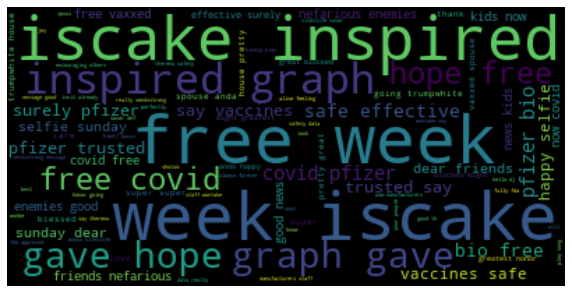

In [ ]:
df_top_positive=df_positive.head(100)
#Popular words in negative tweets
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
tweet_All = " ".join(review for review in df_top_positive.text_word)
fig, ax = plt.subplots(1, 1, figsize  = (10,10))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=48, max_words=100, background_color="black").generate(tweet_All)
# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.axis('off')

(-0.5, 399.5, 199.5, -0.5)

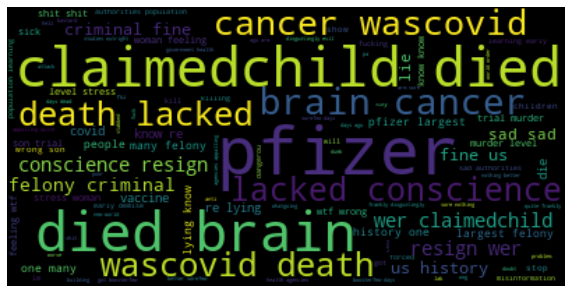

In [ ]:
df_top_negative=df_negative.head(100)
#Popular words in negative tweets
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
tweet_All = " ".join(review for review in df_top_negative.text_word)
fig, ax = plt.subplots(1, 1, figsize  = (10,10))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=48, max_words=100, background_color="black").generate(tweet_All)
# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.axis('off')